# On- and Off-diagonal aggregate plots

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import multiprocess as mp
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler
import re
import bbi
import pairtools
import os
from pybedtools import bedtool
import pybedtools
import pyranges
from matplotlib.gridspec import GridSpec
from cooltools import snipping

In [4]:
mm10 = bioframe.fetch_chromsizes('mm10')
chromsizes = bioframe.fetch_chromsizes('mm10')
chromosomes = list(chromsizes.index)

supports = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]

# On-diagonal pile-up: Top AsiS1 DSBs

In [5]:
#naming 
pathDir = "/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers"

conditions = [
    '1',
    '2'
]

short_names = {
    '1':'ND-dmso',
    '2':'4OHT-dmso'
}


long_names = {
    '1' : 'JZ-MEF-AsiS1-ND-dmso6h-HiCD2R1',
    '2' : 'JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R1'    
}


coolerfile = {}
for cond in conditions:
    coolerfile[cond] = '{}/{}.mm10.nodups.65M.1000.mcool::resolutions/25000'.format(pathDir, long_names[cond])
    
clrs = {
    cond: cooler.Cooler(coolerfile[cond]) for cond in conditions
}
binsize = 25000
resolution=binsize


In [6]:
clrs

{'1': <Cooler "JZ-MEF-AsiS1-ND-dmso6h-HiCD2R1.mm10.nodups.65M.1000.mcool::/resolutions/25000">,
 '2': <Cooler "JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R1.mm10.nodups.65M.1000.mcool::/resolutions/25000">}

In [29]:
#Computing expected in cis
for cond in conditions:
    mcoolfile = coolerfile[cond]
    expectedfile = '{}/{}.mm10.25000.cis.expected'.format(pathDir, long_names[cond])
    !bsub -q short -W 04:00 -n 4 -R "span[hosts=1]" -R "select[rh=8]" -R rusage[mem=24000] \
        "source activate coolerenv_manual_master; cooltools compute-expected -p 4 -t cis $mcoolfile -o $expectedfile"

INFO: Total memory requested is 96000 MB (4 cores x 24000 MB)
Job <1549089> is submitted to queue <short>.
INFO: Total memory requested is 96000 MB (4 cores x 24000 MB)
Job <1549090> is submitted to queue <short>.


In [55]:
sites=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/mm10bins_25000_top97.bed', sep = "\t", index_col=None, names=['chrom','start','end'])
sites['strand']='-'
len(sites)
sites.head()


,chrom,start,end,strand
0,chr1,64100000,64125000,-
1,chr1,89450000,89475000,-
2,chr1,125425000,125450000,-
3,chr1,131125000,131150000,-
4,chr1,133125000,133150000,-


In [56]:
supports = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]

flank = 1000000
windows = snipping.make_bin_aligned_windows(
    resolution, 
    sites['chrom'], 
    sites['start'],
    flank_bp=flank)
windows['strand'] = sites['strand']
windows = snipping.assign_regions(windows, supports)
windows = windows.dropna()

print(len(windows), 'windows, after assigning supports')
windows.head()


94 windows, after assigning supports


,chrom,start,end,lo,hi,strand,region
0,chr1,63100000,65125000,2524,2605,-,chr1:0-195471971
1,chr1,88450000,90475000,3538,3619,-,chr1:0-195471971
2,chr1,124425000,126450000,4977,5058,-,chr1:0-195471971
3,chr1,130125000,132150000,5205,5286,-,chr1:0-195471971
4,chr1,132125000,134150000,5285,5366,-,chr1:0-195471971


In [57]:
# Set up parallelization
import multiprocess
nthreads = 8

In [58]:
piles = {}

for cond in conditions:
    print("working on {} condition".format(cond))
    expected = pd.read_table('{}/{}.mm10.25000.cis.expected'.format(pathDir, long_names[cond]),
                          sep = "\t")
    oe_snipper = cooltools.snipping.ObsExpSnipper(clrs[cond], expected)
    
    with multiprocess.Pool(nthreads) as pool:
        stack = cooltools.snipping.pileup(
                windows,
                oe_snipper.select,
                oe_snipper.snip,
                map=pool.map
                )
    
    # mirror reflect snippets whose feature is on the opposite strand: in this case nothing flips
    mask = np.array(windows.strand == '-', dtype=bool)
    stack[:, :, mask] = stack[::-1, ::-1, mask]
    
#     stacks[cond] = stack
    piles[cond] = np.nanmean(stack, axis=2)
    

working on 1 condition


/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


working on 2 condition


Text(0.5, 0.98, 'Top DSBs\nHi-C resolution = 25kb; # of sites = 94, flank=1000000')

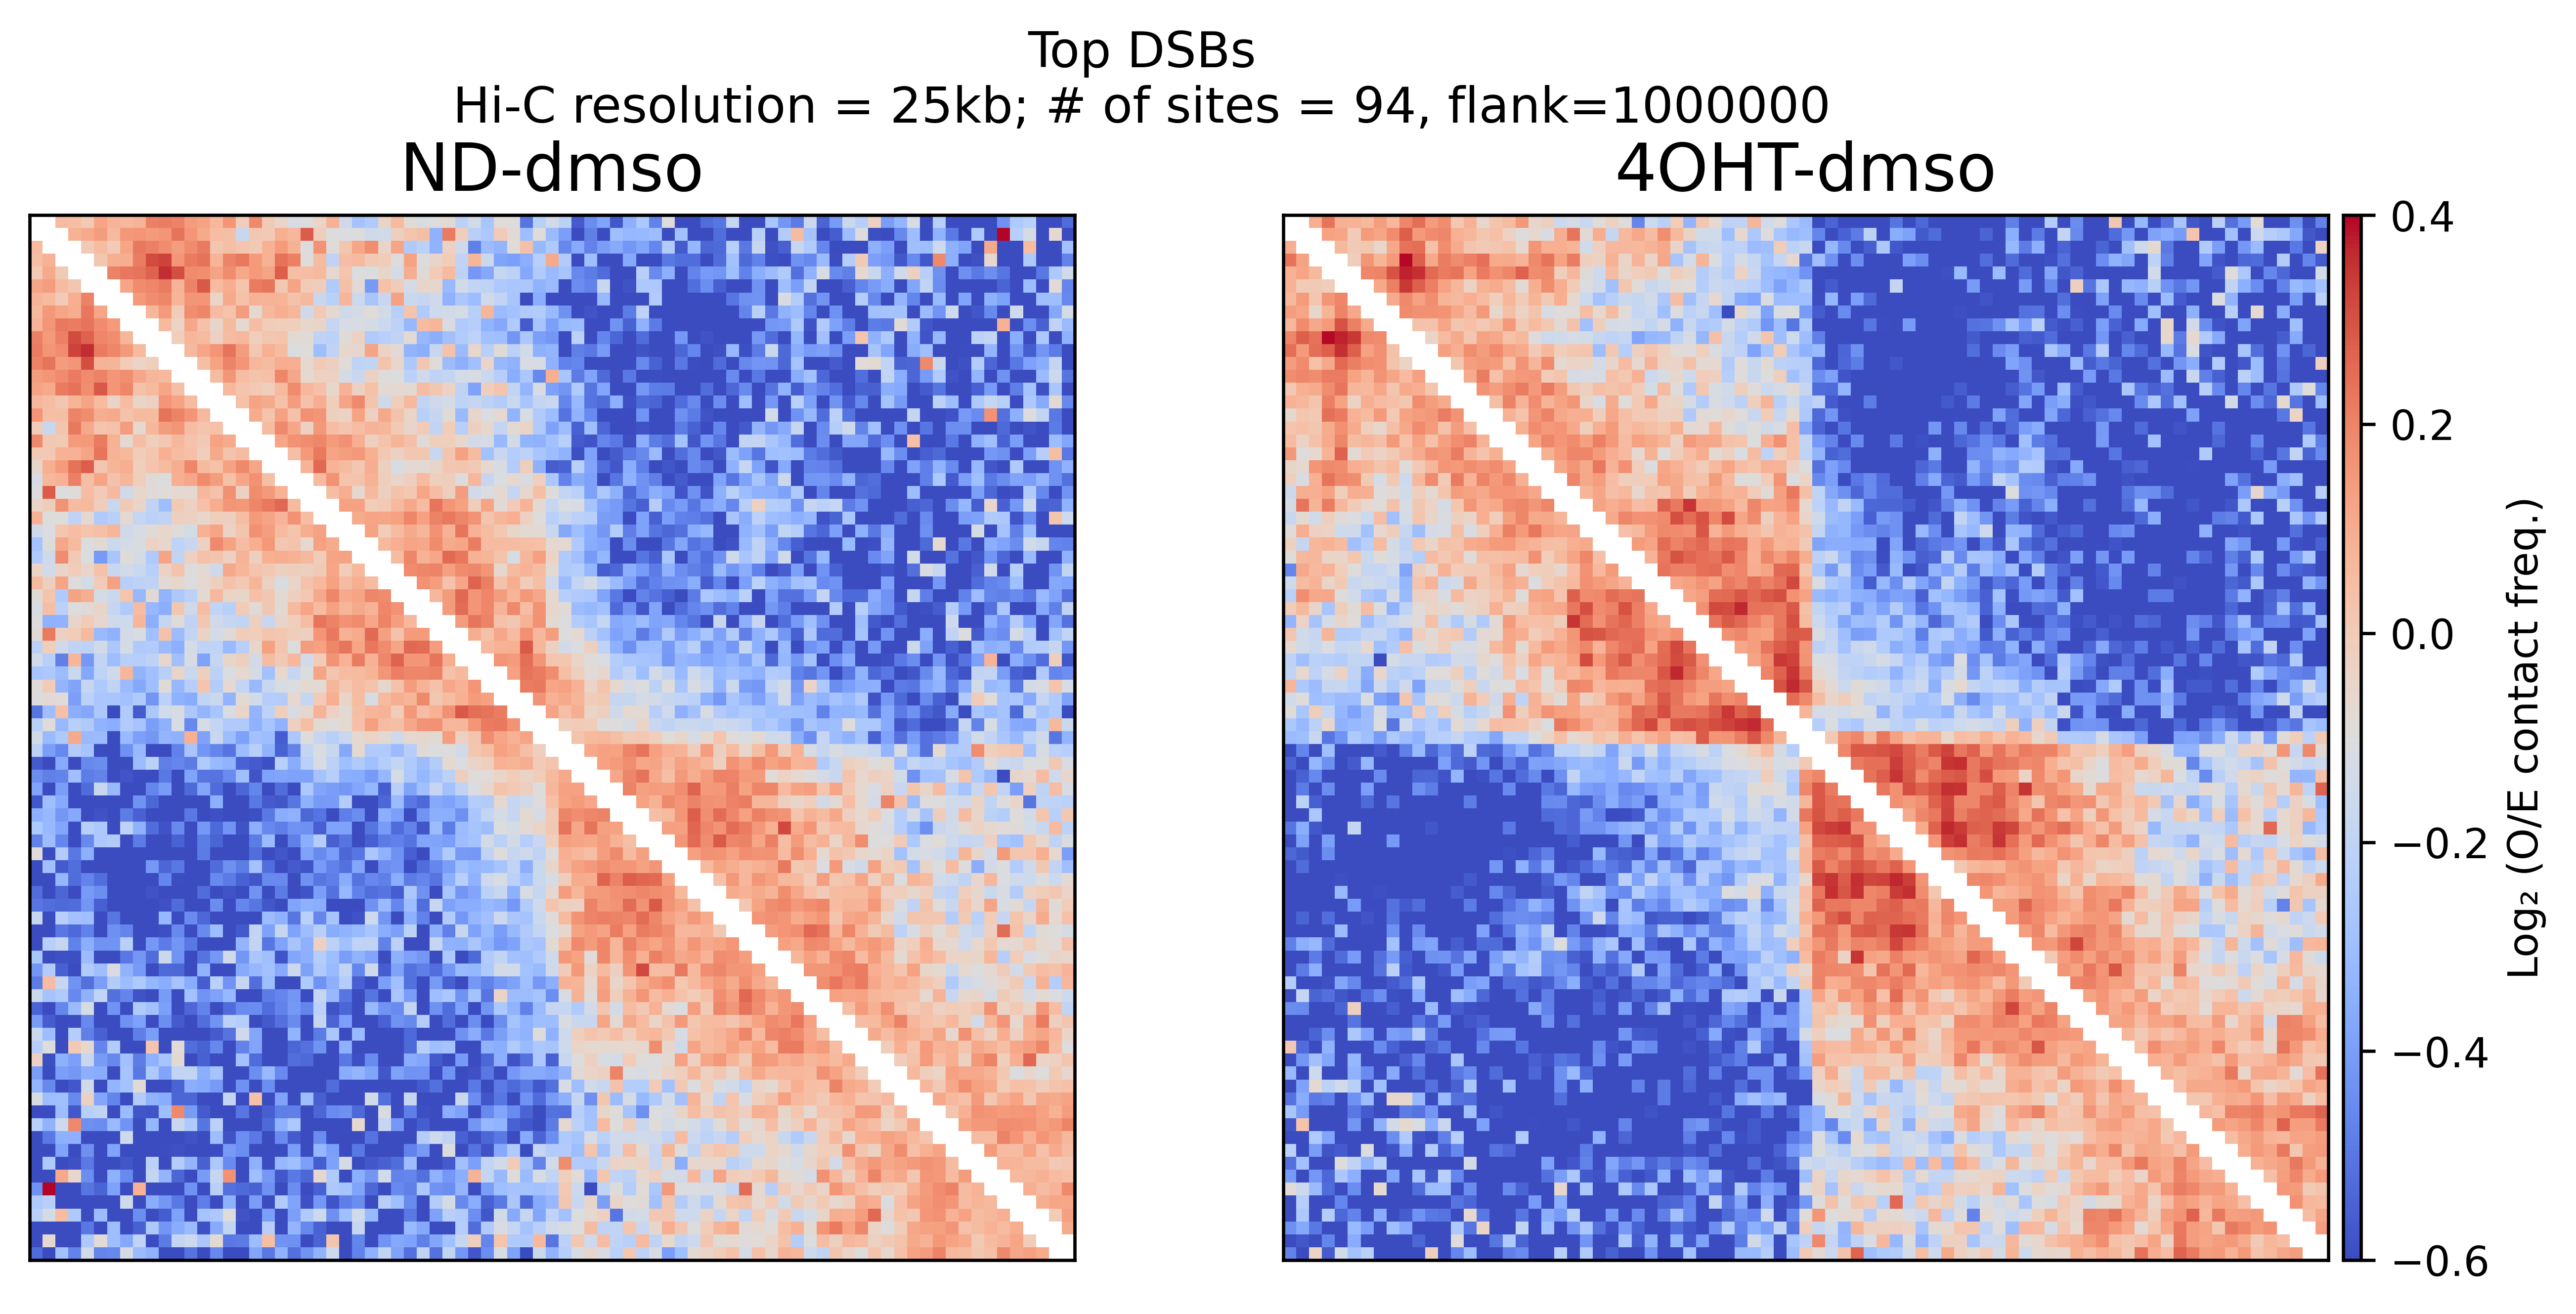

In [59]:
gs = GridSpec(nrows=1, ncols=2, width_ratios=[20] * 2)
fig=plt.figure(figsize=(5 * 2, 5),dpi=600)

opts = dict(
    vmin=-0.6,
    vmax=0.4,
    extent=[-flank//1000000, flank//1000000, -flank//1000000, flank//1000000],
    cmap='coolwarm'
)

for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        np.log2(piles[cond]),  
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(short_names[cond],fontsize=16)
    plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)

cax = fig.add_axes([ax.get_position().x1+0.005,ax.get_position().y0,0.006,ax.get_position().height])
plt.colorbar(img, cax=cax,label='Log\N{SUBSCRIPT TWO} (O/E contact freq.)', pad=40)
plt.suptitle(f'Top DSBs\n'
             f'Hi-C resolution = {binsize//1000}kb; # of sites = {len(windows)}, flank={flank}')

#fig.tight_layout()
#plt.savefig("*.pdf", dpi=300)


# On-diagonal pile-up: CTCF

In [62]:
#naming 
pathDir = "/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers"

conditions = [
    '1',
    '2'
]

short_names = {
    '1':'ND-dmso',
    '2':'4OHT-dmso'
}


long_names = {
    '1' : 'JZ-MEF-AsiS1-ND-dmso6h-HiCD2R1',
    '2' : 'JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R1'    
}


coolerfile = {}
for cond in conditions:
    coolerfile[cond] = '{}/{}.mm10.nodups.65M.1000.mcool::resolutions/5000'.format(pathDir, long_names[cond])
    
clrs = {
    cond: cooler.Cooler(coolerfile[cond]) for cond in conditions
}
binsize = 5000
resolution=binsize

In [63]:
clrs

{'1': <Cooler "JZ-MEF-AsiS1-ND-dmso6h-HiCD2R1.mm10.nodups.65M.1000.mcool::/resolutions/5000">,
 '2': <Cooler "JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R1.mm10.nodups.65M.1000.mcool::/resolutions/5000">}

In [32]:
#Computing expected in cis
for cond in conditions:
    mcoolfile = coolerfile[cond]
    expectedfile = '{}/{}.mm10.5000.cis.expected'.format(pathDir, long_names[cond])
    !bsub -q short -W 04:00 -n 4 -R "span[hosts=1]" -R "select[rh=8]" -R rusage[mem=24000] \
        "source activate coolerenv_manual_master; cooltools compute-expected -p 4 -t cis $mcoolfile -o $expectedfile"

INFO: Total memory requested is 96000 MB (4 cores x 24000 MB)
Job <1549091> is submitted to queue <short>.
INFO: Total memory requested is 96000 MB (4 cores x 24000 MB)
Job <1549092> is submitted to queue <short>.


In [64]:
sites=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/ctcf.motif.at.GSM2635593.peaks.200bp.mm10.bed', sep = "\t", index_col=None, names=['chrom', 'start',  'end', '-', 'score', 'strand', 'chrom2', 'start2',  'end2', '-2', 'score_peak'])
len(sites)
sites.head()


,chrom,start,end,-,score,strand,chrom2,start2,end2,-2,score_peak
0,chr10,3229366,3229385,Kim_etal_PWM_CTCF_bindingMotif,7.953636,+,chr10,3229312,3229513,GSM2635593_ChIP_seq_CTCF_MEF_macs3_peak_8613,5.97839
1,chr10,3333054,3333073,Kim_etal_PWM_CTCF_bindingMotif,9.756691,+,chr10,3333054,3333255,GSM2635593_ChIP_seq_CTCF_MEF_macs3_peak_8616,83.96920
2,chr10,3406495,3406514,Kim_etal_PWM_CTCF_bindingMotif,12.404276,-,chr10,3406510,3406711,GSM2635593_ChIP_seq_CTCF_MEF_macs3_peak_8623,11.44930
3,chr10,3534541,3534560,Kim_etal_PWM_CTCF_bindingMotif,15.386362,+,chr10,3534516,3534717,GSM2635593_ChIP_seq_CTCF_MEF_macs3_peak_8627,50.00640
4,chr10,3568009,3568028,Kim_etal_PWM_CTCF_bindingMotif,8.855613,-,chr10,3567998,3568199,GSM2635593_ChIP_seq_CTCF_MEF_macs3_peak_8630,20.73870


In [65]:
supports = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]

flank = 100000
windows = snipping.make_bin_aligned_windows(
    resolution, 
    sites['chrom'], 
    sites['start'],
    flank_bp=flank)
windows['strand'] = sites['strand']
windows = snipping.assign_regions(windows, supports)
windows = windows.dropna()

print(len(windows), 'windows, after assigning supports')
windows.head()


13927 windows, after assigning supports


,chrom,start,end,lo,hi,strand,region
0,chr10,3125000,3330000,625,666,+,chr10:0-130694993
1,chr10,3230000,3435000,646,687,+,chr10:0-130694993
2,chr10,3305000,3510000,661,702,-,chr10:0-130694993
3,chr10,3430000,3635000,686,727,+,chr10:0-130694993
4,chr10,3465000,3670000,693,734,-,chr10:0-130694993


In [66]:
# Set up parallelization
import multiprocess
nthreads = 8

In [67]:
piles = {}

for cond in conditions:
    print("working on {} condition".format(cond))
    expected = pd.read_table('{}/{}.mm10.5000.cis.expected'.format(pathDir, long_names[cond]),
                          sep = "\t")
    oe_snipper = cooltools.snipping.ObsExpSnipper(clrs[cond], expected)
    
    with multiprocess.Pool(nthreads) as pool:
        stack = cooltools.snipping.pileup(
                windows,
                oe_snipper.select,
                oe_snipper.snip,
                map=pool.map
                )
    
    # IMPORTANT for CTCF:
    #mirror reflect snippets whose feature is on the opposite strand
    mask = np.array(windows.strand == '-', dtype=bool)
    stack[:, :, mask] = stack[::-1, ::-1, mask]
    
#     stacks[cond] = stack
    piles[cond] = np.nanmean(stack, axis=2)
    

working on 1 condition


/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


working on 2 condition


Text(0.5, 0.98, 'CTCF peaks at motifs\nHi-C resolution = 5kb; # of sites = 13927, flank=100000')

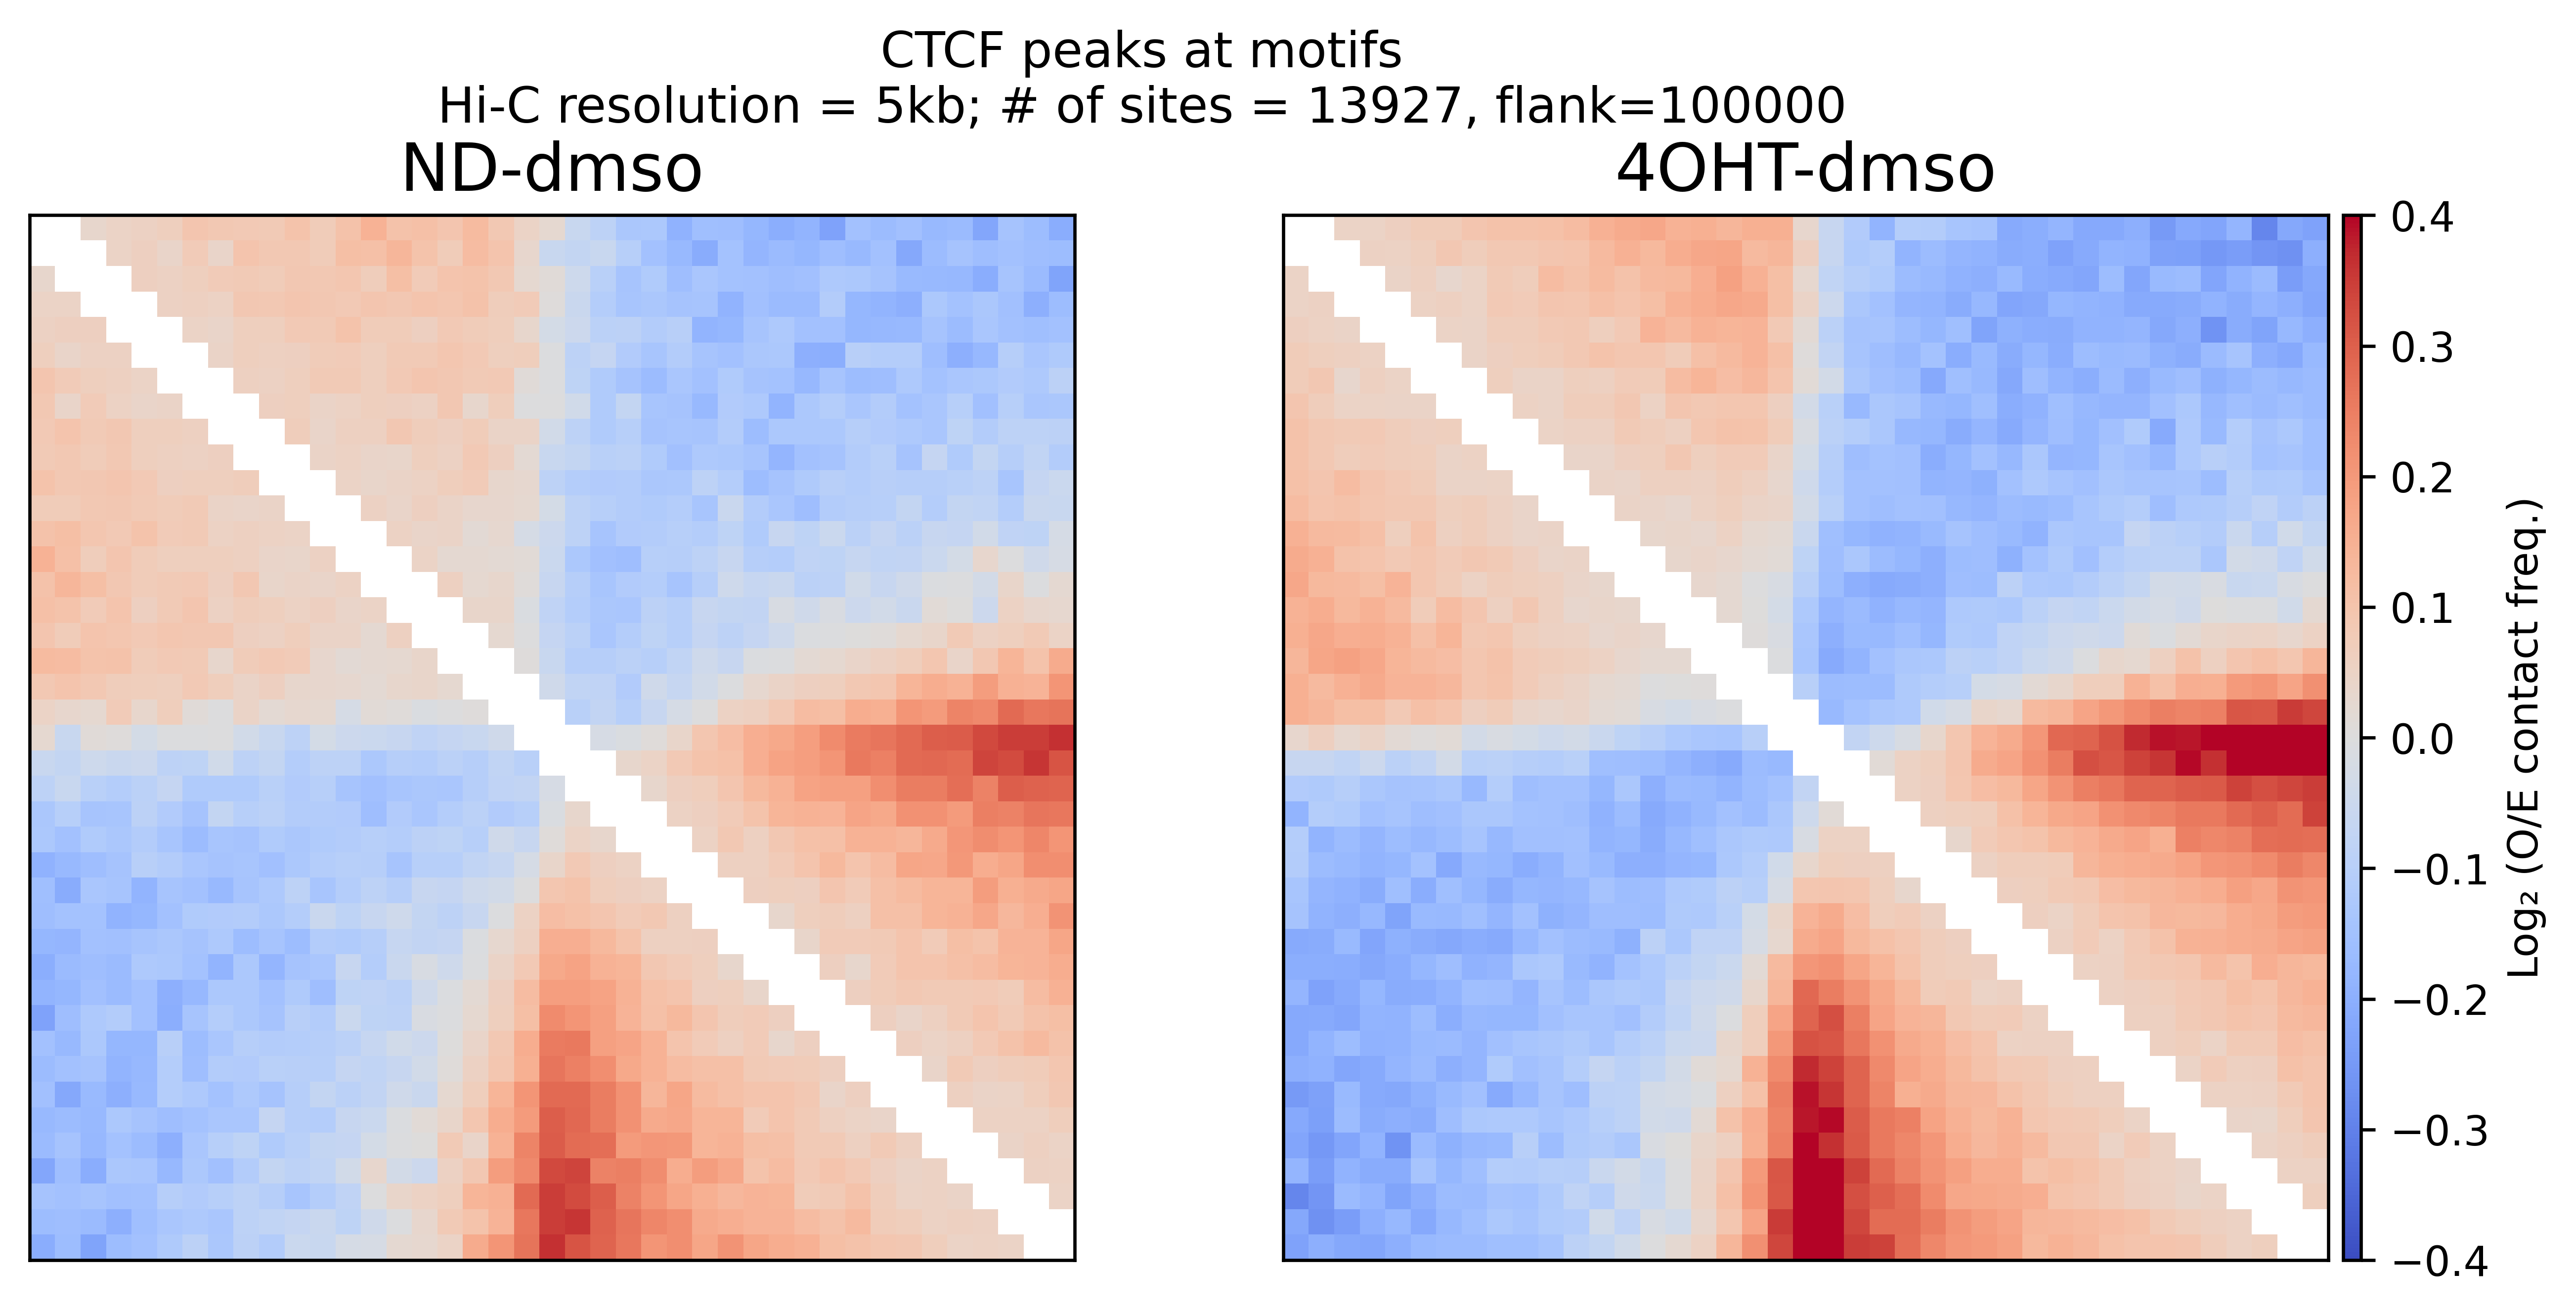

In [68]:
gs = GridSpec(nrows=1, ncols=2, width_ratios=[20] * 2)
fig=plt.figure(figsize=(5 * 2, 5),dpi=600)

opts = dict(
    vmin=-0.4,
    vmax=0.4,
    extent=[-flank//1000000, flank//1000000, -flank//1000000, flank//1000000],
    cmap='coolwarm'
)

for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        np.log2(piles[cond]),  
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(short_names[cond],fontsize=16)
    plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)

cax = fig.add_axes([ax.get_position().x1+0.005,ax.get_position().y0,0.006,ax.get_position().height])
plt.colorbar(img, cax=cax,label='Log\N{SUBSCRIPT TWO} (O/E contact freq.)', pad=40)
plt.suptitle(f'CTCF peaks at motifs\n'
             f'Hi-C resolution = {binsize//1000}kb; # of sites = {len(windows)}, flank={flank}')

#fig.tight_layout()
#plt.savefig("*.pdf", dpi=300)


# Off-diagonal pile-up: Top AsiS1 clustering

In [39]:
#naming 
pathDir = "/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers"

conditions = [
    '1',
    '2'
]

short_names = {
    '1':'ND-dmso',
    '2':'4OHT-dmso'
}


long_names = {
    '1' : 'JZ-MEF-AsiS1-ND-dmso6h-HiCD2R1',
    '2' : 'JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R1'    
}


coolerfile = {}
for cond in conditions:
    coolerfile[cond] = '{}/{}.mm10.nodups.65M.1000.mcool::resolutions/25000'.format(pathDir, long_names[cond])
    
clrs = {
    cond: cooler.Cooler(coolerfile[cond]) for cond in conditions
}
binsize = 25000
resolution=binsize

In [40]:
#all pairwise combinations of Top sites
dots=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/mm10bins_25000_top97_COMBOS.bed', sep= '\t',names=['chrom1', 'start1', 'end1','chrom2', 'start2', 'end2','x'] ,index_col=None)
dots.head()


,chrom1,start1,end1,chrom2,start2,end2,x
0,chr1,64100000,64125000,chr1,89450000,89475000,1
1,chr1,64100000,64125000,chr1,125425000,125450000,1
2,chr1,64100000,64125000,chr1,131125000,131150000,1
3,chr1,64100000,64125000,chr1,133125000,133150000,1
4,chr1,64100000,64125000,chr1,143725000,143750000,1


In [41]:
##cis combos only
dots=dots[dots['chrom1']==dots['chrom2']]
dots=dots[dots['start1']!=dots['start2']]
len(dots)


304

In [42]:
sites = dots
sites['width1'] = sites['end1'] - sites['start1']
sites['width2'] = sites['end2'] - sites['start2']
sites.head()
len(sites)


304

In [43]:
#add midpoints
sites['mid1'] = sites.end1 - sites.width1/2
sites['mid2'] = sites.end2 - sites.width2/2
print(len(sites))


304


In [44]:
snippet_flank = 1000000

windows1 = snipping.make_bin_aligned_windows(
    binsize, 
    dots['chrom1'], 
    dots['mid1'],
    flank_bp=snippet_flank)
windows1['strand'] = '.'

windows2 = snipping.make_bin_aligned_windows(
    binsize, 
    dots['chrom2'], 
    dots['mid2'],
    flank_bp=snippet_flank)
windows2['strand'] = '.'

windows = pd.merge(windows1, windows2, left_index=True, right_index=True, suffixes=('1', '2'))
windows = snipping.assign_regions(windows, supports)
windows = windows.dropna()
windows.head()


,chrom1,start1,end1,lo1,hi1,strand1,chrom2,start2,end2,lo2,hi2,strand2,region
0,chr1,63100000,65125000,2524,2605,.,chr1,88450000,90475000,3538,3619,.,chr1:0-195471971
1,chr1,63100000,65125000,2524,2605,.,chr1,124425000,126450000,4977,5058,.,chr1:0-195471971
2,chr1,63100000,65125000,2524,2605,.,chr1,130125000,132150000,5205,5286,.,chr1:0-195471971
3,chr1,63100000,65125000,2524,2605,.,chr1,132125000,134150000,5285,5366,.,chr1:0-195471971
4,chr1,63100000,65125000,2524,2605,.,chr1,142725000,144750000,5709,5790,.,chr1:0-195471971


In [45]:
# Set up parallelization
import multiprocess
nthreads = 8

In [46]:
piles = {}
stacks = {}

for cond in conditions:
    print("working on {} condition".format(cond))
    expected = pd.read_table('{}/{}.mm10.25000.cis.expected'.format(pathDir, long_names[cond]))
    
    oe_snipper = cooltools.snipping.ObsExpSnipper(clrs[cond], expected)
    
    # create the stack of snips:
    with multiprocess.Pool(nthreads) as pool:
        stack = cooltools.snipping.pileup(
            windows,
            oe_snipper.select,
            oe_snipper.snip,
            map=pool.map
            )
    stacks[cond] = stack
    piles[cond] = np.nanmean(stack, axis=2)

working on 1 condition
working on 2 condition


Text(0.5, 0.98, 'Hi-C resolution = 25kb; # of pairs = 304,flank=1000000')

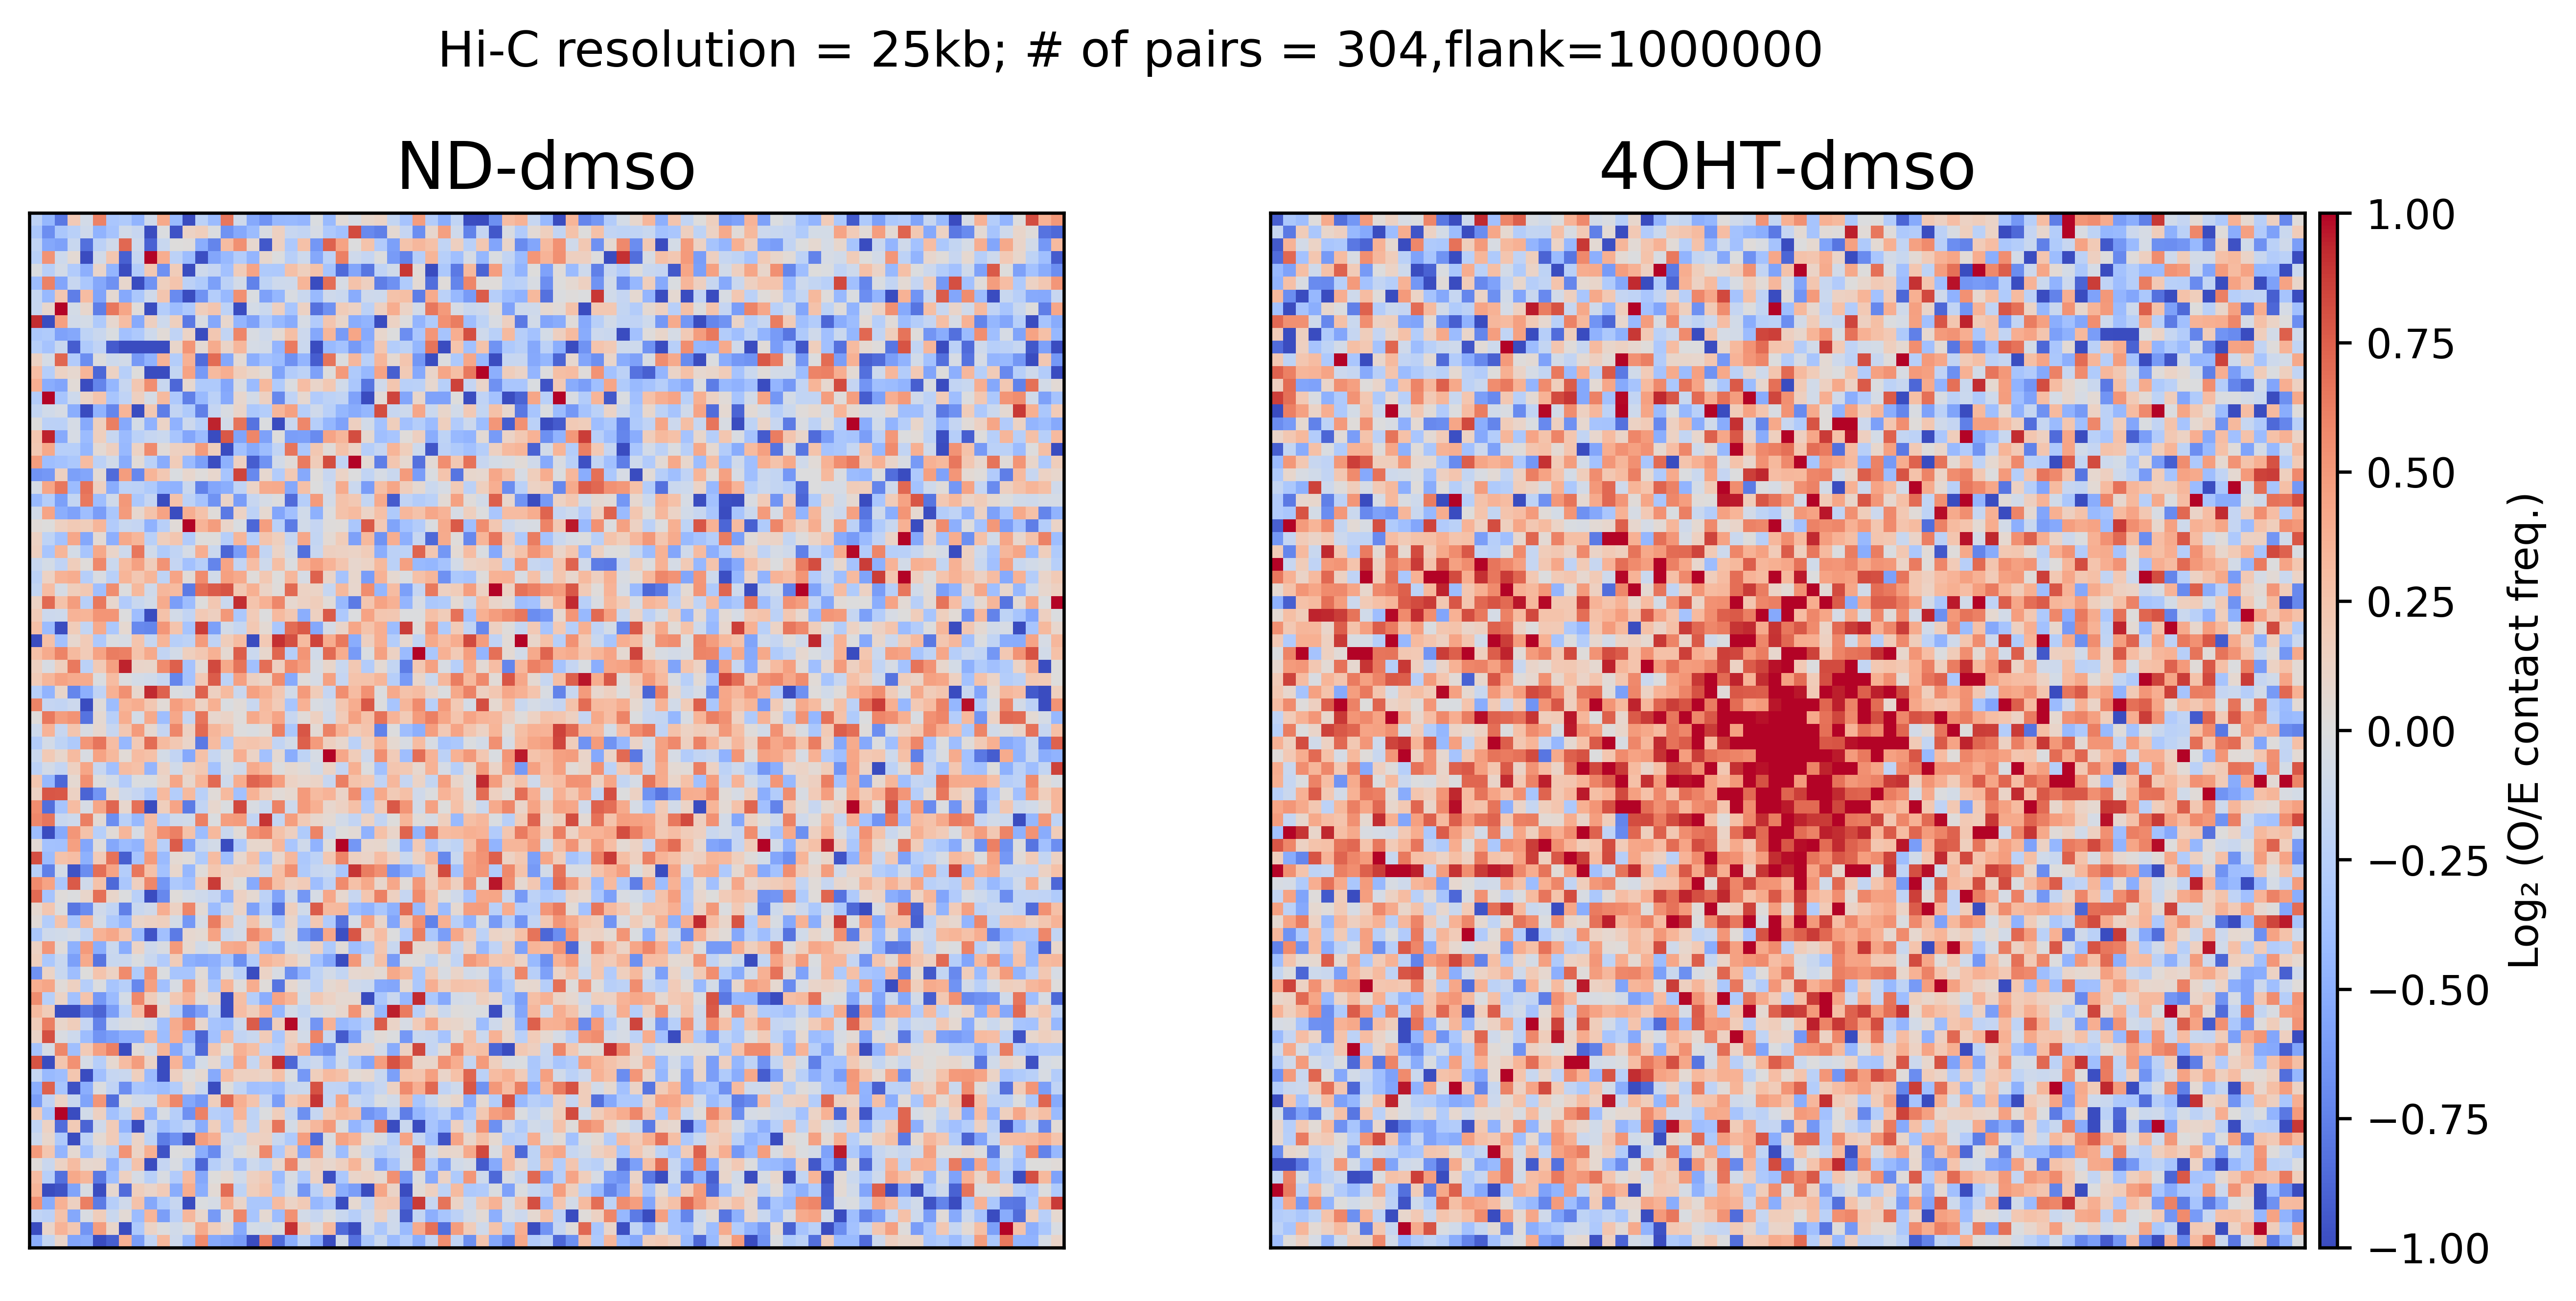

In [47]:
gs = GridSpec(nrows=1, ncols=2, width_ratios=[20] * 2)
fig=plt.figure(figsize=(5 * 2, 5),dpi=600)

opts = dict(
    vmin=-1,
    vmax=1,
    extent=[-snippet_flank//1000, snippet_flank//1000, -snippet_flank//1000, snippet_flank//1000],
    cmap='coolwarm'
)
for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        np.log2(np.nanmean(stacks[cond], axis=2)),  
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(short_names[cond],fontsize=16)
    plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)

cax = fig.add_axes([ax.get_position().x1+0.005,ax.get_position().y0,0.006,ax.get_position().height])
plt.colorbar(img, cax=cax,label='Log\N{SUBSCRIPT TWO} (O/E contact freq.)', pad=40)

plt.suptitle(f'Hi-C resolution = {binsize//1000}kb; # of pairs = {len(windows)},flank={snippet_flank}')
#plt.savefig("*.pdf", bbox_inches='tight')



In [48]:
#Calculating looping score for 9x9 cluster @25kb
clusterScore = {}
mcenter={}
moutside={}

for cond in conditions:
    
    #select just center 9 squares (40x40 array)
    center = piles[cond][np.ix_([36,37,38,39,40,41,42,43,44], [36,37,38,39,40,41,42,43,44])]
    
    #delete 3 center columns and 3 center rows
    outside=np.delete(np.delete(piles[cond],[[36,37,38,39,40,41,42,43,44], [36,37,38,39,40,41,42,43,44]],axis=0),[[36,37,38,39,40,41,42,43,44], [36,37,38,39,40,41,42,43,44]], axis=1)
    #calculate center-outside for each sample
    mcenter[cond]=np.nanmean(center)
    moutside[cond]=np.nanmean(outside)
    clusterScore[cond] = np.nanmean(center)/np.nanmean(outside)
    

In [49]:
clusterScore

{'1': 1.2250137840253024, '2': 1.9213237495923463}

# Off-diagonal pile-up: CTCF loops

In [18]:
#naming 
pathDir = "/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers"

conditions = [
    '1',
    '2'
]

short_names = {
    '1':'ND-dmso',
    '2':'4OHT-dmso'
}


long_names = {
    '1' : 'JZ-MEF-AsiS1-ND-dmso6h-HiCD2R1',
    '2' : 'JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R1'    
}


coolerfile = {}
for cond in conditions:
    coolerfile[cond] = '{}/{}.mm10.nodups.65M.1000.mcool::resolutions/5000'.format(pathDir, long_names[cond])
    
clrs = {
    cond: cooler.Cooler(coolerfile[cond]) for cond in conditions
}
binsize = 5000
resolution=binsize

In [19]:
dots=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/data/ctcf.motif.at.peaks.200bp.mm10_noheader_COMBOS_wstrand.bed', sep= '\t',names=['chrom1', 'start1', 'end1','s1','chrom2', 'start2', 'end2','s2','diff_bin'] ,index_col=None)


In [21]:
##cis
dots=dots[dots['chrom1']==dots['chrom2']]
dots=dots[dots['start1']!=dots['start2']]
#covergent CTCF only
dots=dots[(dots['s1']=='-') & (dots['s2']=='+')]
#limit distance for loops
dots['diff_bin']=abs(dots['start1']-dots['start2'])
dots=dots[(dots['diff_bin']>=250000) & (dots['diff_bin']<=1000000)]

len(dots)


47523

In [22]:
sites = dots
sites['width1'] = sites['end1'] - sites['start1']
sites['width2'] = sites['end2'] - sites['start2']
sites.head()
len(sites)


47523

In [23]:
#add midpoints
sites['mid1'] = sites.end1 - sites.width1/2
sites['mid2'] = sites.end2 - sites.width2/2
print(len(sites))


47523


In [25]:
snippet_flank = 100000

windows1 = snipping.make_bin_aligned_windows(
    binsize, 
    dots['chrom1'], 
    dots['mid1'],
    flank_bp=snippet_flank)
windows1['strand'] = '.'

windows2 = snipping.make_bin_aligned_windows(
    binsize, 
    dots['chrom2'], 
    dots['mid2'],
    flank_bp=snippet_flank)
windows2['strand'] = '.'

windows = pd.merge(windows1, windows2, left_index=True, right_index=True, suffixes=('1', '2'))
windows = snipping.assign_regions(windows, supports)
windows = windows.dropna()
windows.tail()


,chrom1,start1,end1,lo1,hi1,strand1,chrom2,start2,end2,lo2,hi2,strand2,region
177256086,chrX,163055000,163260000,32611,32652,.,chrX,163445000,163650000,32689,32730,.,chrX:0-171031299
177256087,chrX,163055000,163260000,32611,32652,.,chrX,163570000,163775000,32714,32755,.,chrX:0-171031299
177256088,chrX,163055000,163260000,32611,32652,.,chrX,163965000,164170000,32793,32834,.,chrX:0-171031299
177256179,chrX,167175000,167380000,33435,33476,.,chrX,167715000,167920000,33543,33584,.,chrX:0-171031299
177256185,chrX,167395000,167600000,33479,33520,.,chrX,167715000,167920000,33543,33584,.,chrX:0-171031299


In [26]:
# Set up parallelization
import multiprocess
nthreads = 8

In [28]:
piles = {}
stacks = {}

for cond in conditions:
    print("working on {} condition".format(cond))
    expected = pd.read_table('{}/{}.mm10.5000.cis.expected'.format(pathDir, long_names[cond]))
    
    oe_snipper = cooltools.snipping.ObsExpSnipper(clrs[cond], expected)
    
    # create the stack of snips:
    with multiprocess.Pool(nthreads) as pool:
        stack = cooltools.snipping.pileup(
            windows,
            oe_snipper.select,
            oe_snipper.snip,
            map=pool.map
            )
    stacks[cond] = stack
    piles[cond] = np.nanmean(stack, axis=2)


working on 1 condition
working on 2 condition


Text(0.5, 0.98, 'Hi-C resolution = 5kb; # of pairs = 47523,flank=100000')

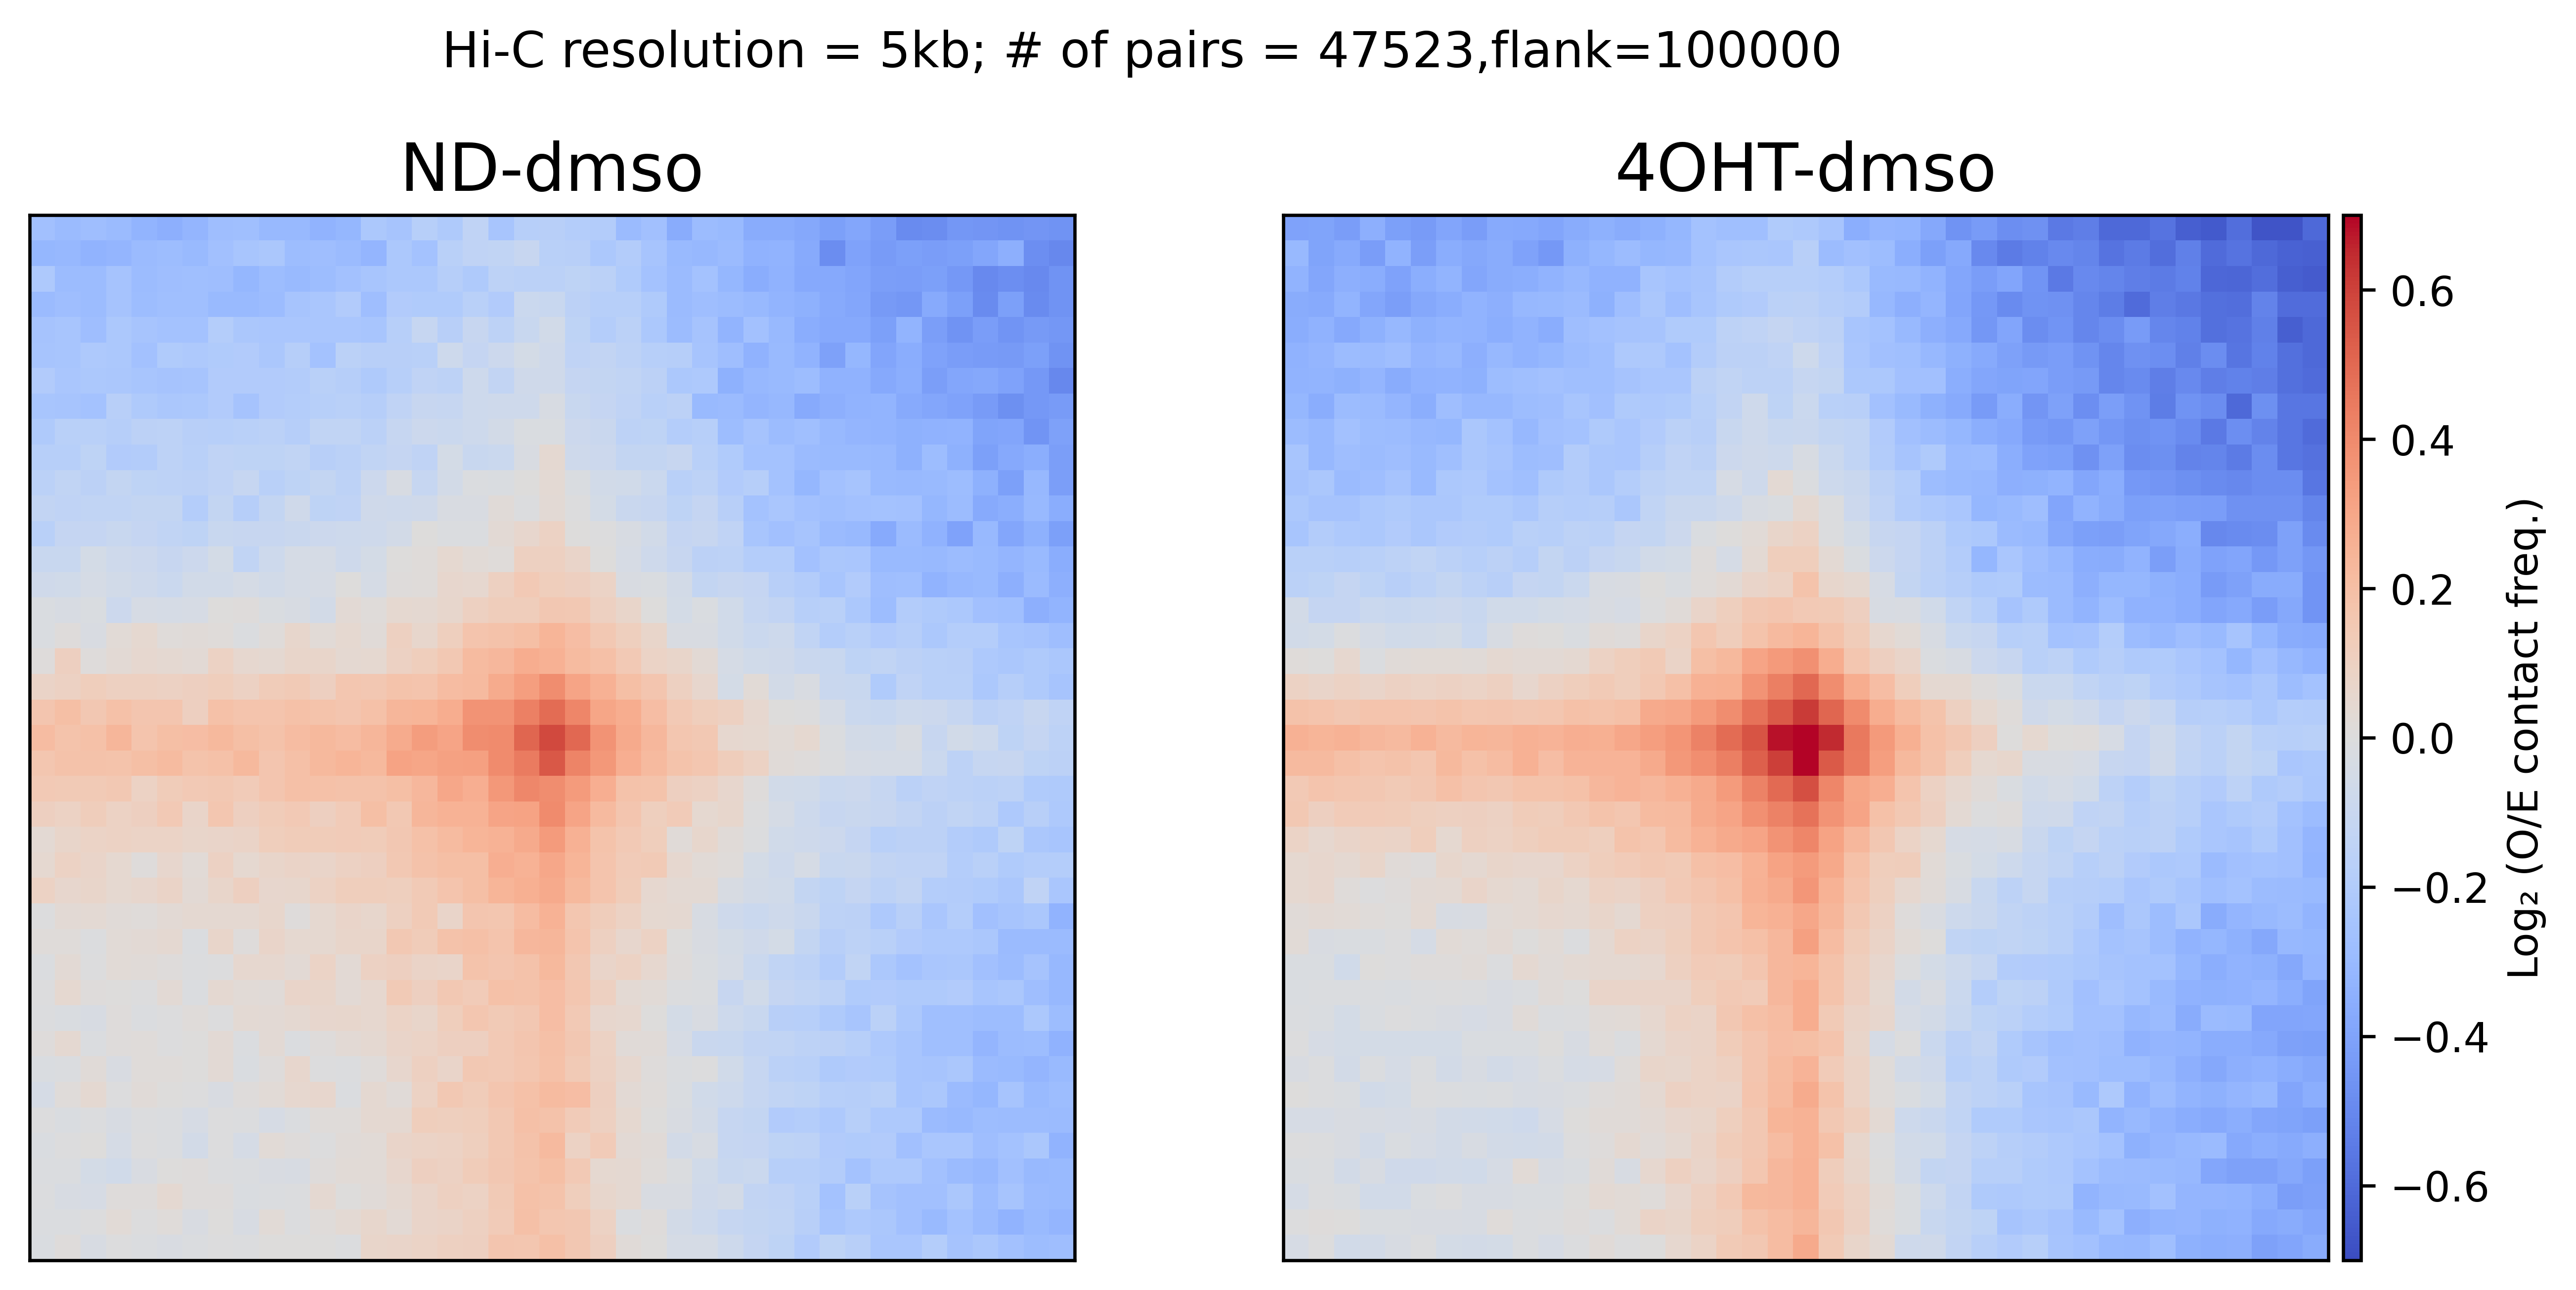

In [31]:
gs = GridSpec(nrows=1, ncols=2, width_ratios=[20] * 2)
fig=plt.figure(figsize=(5 * 2, 5),dpi=600)

opts = dict(
    vmin=-0.7,
    vmax=0.7,
    extent=[-snippet_flank//1000, snippet_flank//1000, -snippet_flank//1000, snippet_flank//1000],
    cmap='coolwarm'
)
for i, cond in enumerate(conditions[0:6]):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        np.log2(np.nanmean(stacks[cond], axis=2)), #piles[cond]),  
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(short_names[cond],fontsize=16)
    plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)

#ax = plt.subplot(gs[len(conditions[4:8])])
cax = fig.add_axes([ax.get_position().x1+0.005,ax.get_position().y0,0.006,ax.get_position().height])
plt.colorbar(img, cax=cax,label='Log\N{SUBSCRIPT TWO} (O/E contact freq.)', pad=40)

plt.suptitle(f'Hi-C resolution = {binsize//1000}kb; # of pairs = {len(windows)},flank={snippet_flank}')
#plt.savefig("*.pdf", bbox_inches='tight')



In [37]:
#Calculating looping score for 5x5 dot @5kb
loopScore = {}
mcenter={}
moutside={}

for cond in conditions:
    
    #select just center 5 squares (40x40 array)
    center = piles[cond][np.ix_([18,19,20,21,22], [18,19,20,21,22])]
    
    #delete 3 center columns and 3 center rows
    outside = np.delete(np.delete(piles[cond], [[18,19,20,21,22], [18,19,20,21,22]], axis = 0), [[18,19,20,21,22], [18,19,20,21,22]], axis = 1)
    #calculate center-outside for each sample
    mcenter[cond]=np.nanmean(center)
    moutside[cond]=np.nanmean(outside)
    loopScore[cond] = np.nanmean(center)/np.nanmean(outside)


In [38]:
loopScore


{'1': 1.4288783073717435, '2': 1.6149148122910677}